In [1]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import numpy as np
import pandas as pd
import time
import scipy
import random
import operator
import os
import string

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter, ScalarFormatter, MultipleLocator, AutoMinorLocator, LogLocator, LogFormatterSciNotation
from matplotlib.ticker import Locator

from matplotlib.colors import LogNorm
import matplotlib.colors as colors

import matplotlib.cbook as cbook
import matplotlib.font_manager as font_manager

import math

from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Global parameters. Mainly for the graphs.

plt.rcParams['font.family'] = 'Iosevka'
plt.rcParams.update({'font.size': 24})

In [3]:
# Additional Functions that are required for later.

# Credit: ImportanceOfBeingErnest, https://stackoverflow.com/questions/43324152/python-matplotlib-colorbar-scientific-notation-base
class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

# --------------------------------------------------------------------------
# Credit: unutbu, https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# --------------------------------------------------------------------------
# Credit: David Zwicker and Matt Pitkin, https://stackoverflow.com/questions/20470892/how-to-place-minor-ticks-on-symlog-scale
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

In [4]:
# Reading data and processing as dataframe. The master dataframe is termed df1.

# Normally, I have all the data (it took 4-5 days to thrawl for 250,000+ nations), but for sake of size and GitHub, this is the random choice of 50000 nations.
folder = "data"
file_name = "2020-06-(08-11) (Sample Data).csv"
file_path = os.path.join(folder, file_name)

df1 =  pd.read_csv(file_path)
df1.index = df1.index + 1

pd.set_option('display.max_columns', 500) # Show all the columns (max 500, but we will have maybe 400 col max)

df1

,Index No.,Nation Name,Category,Region Name,Flag,Percentage Government Expenditure: Administration,Percentage Government Expenditure: Defence,Percentage Government Expenditure: Education,Percentage Government Expenditure: Environment,Percentage Government Expenditure: Healthcare,Percentage Government Expenditure: Commerce,Percentage Government Expenditure: International Aid,Percentage Government Expenditure: Law and Order,Percentage Government Expenditure: Public Transport,Percentage Government Expenditure: Social Equality,Percentage Government Expenditure: Spirituality,Percentage Government Expenditure: Welfare,Percentage Market Sector: Black Market,Percentage Market Sector: Government,Percentage Market Sector: Industry,Percentage Market Sector: Public,Percentage Death Type: Accident,Percentage Death Type: Acts of God,Percentage Death Type: Animal Attack,Percentage Death Type: Bungee Jumping,Percentage Death Type: Capital Punishment,Percentage Death Type: Cancer,Percentage Death Type: Disappearance,Percentage Death Type: Exposure,Percentage Death Type: Heart Disease,Percentage Death Type: Involuntary Euthanasia,Percentage Death Type: Lost in Wilderness,Percentage Death Type: Malnourishment,Percentage Death Type: Murder,Percentage Death Type: Nuclear Spill,Percentage Death Type: Old Age,Percentage Death Type: Ritual Sacrifice,Percentage Death Type: Scurvy,Percentage Death Type: Space Shuttle Mishap,Percentage Death Type: Suicide While in Police Custody,Percentage Death Type: Sunburn,Percentage Death Type: Vat Leakage,Percentage Death Type: War,Percentage Death Type: Work,civil rights,civil rights rank,economy,economy rank,political freedoms,political freedoms rank,population,population rank,wealth gaps,wealth gaps rank,death rate,death rate rank,compassion,compassion rank,eco-friendliness,eco-friendliness rank,social conservatism,social conservatism rank,nudity,nudity rank,industry: automobile manufacturing,industry: automobile manufacturing rank,industry: cheese exports,industry: cheese exports rank,industry: basket weaving,industry: basket weaving rank,industry: informtion technology,industry: informtion technology rank,industry: pizza delivery,industry: pizza delivery rank,industry: trout fishing,industry: trout fishing rank,industry: arms manufacturing,industry: arms manufacturing rank,sector: agriculture,sector: agriculture rank,industry: beverage sales,industry: beverage sales rank,industry: timber woodchipping,industry: timber woodchipping rank,industry: mining,industry: mining rank,industry: insurance,industry: insurance rank,industry: furniture restoration,industry: furniture restoration rank,industry: retail,industry: retail rank,industry: book publishing,industry: book publishing rank,industry: gambling,industry: gambling rank,sector: manufacturing,sector: manufacturing rank,government size,government size rank,welfare,welfare rank,public healthcare,public healthcare rank,law enforcement,law enforcement rank,business subsidization,business subsidization rank,religiousness,religiousness rank,income equality,income equality rank,niceness,niceness rank,rudeness,rudeness rank,intelligence,intelligence rank,ignorance,ignorance rank,political apathy,political apathy rank,health,health rank,cheerfulness,cheerfulness rank,weather,weather rank,compliance,compliance rank,safety,safety rank,lifespan,lifespan rank,ideological radicality,ideological radicality rank,defense forces,defense forces rank,pacifism,pacifism rank,economic freedom,economic freedom rank,taxation,taxation rank,freedom from taxation,freedom from taxation rank,corruption,corruption rank,integrity,integrity rank,authoritarianism,authoritarianism rank,youth rebelliousness,youth rebelliousness rank,culture,culture rank,employment,employment rank,public transport,public transport rank,tourism,tourism rank,weaponization,weaponization rank,recreational drug use,recreational drug use rank,obesity,obesity rank,secularism,secularism rank,environmental beauty,environm

In [5]:
# Extra headers for other attributes of a nation. Some were from API, some were calculated.
# These can be done inside the .csv files with Excel forumlas, but Python is definitely A LOT faster.

# Data augmentation / Getting more data from the ones we have gathered.

govt_expenditure_list = ["Percentage Government Expenditure: Administration",
"Percentage Government Expenditure: Defence",
"Percentage Government Expenditure: Education",
"Percentage Government Expenditure: Environment",
"Percentage Government Expenditure: Healthcare",
"Percentage Government Expenditure: Commerce",
"Percentage Government Expenditure: International Aid",
"Percentage Government Expenditure: Law and Order",
"Percentage Government Expenditure: Public Transport",
"Percentage Government Expenditure: Social Equality",
"Percentage Government Expenditure: Spirituality",
"Percentage Government Expenditure: Welfare"]

govt_expenditure_list_absolute = ["Absolute Government Expenditure: Administration",
"Absolute Government Expenditure: Defence",
"Absolute Government Expenditure: Education",
"Absolute Government Expenditure: Environment",
"Absolute Government Expenditure: Healthcare",
"Absolute Government Expenditure: Commerce",
"Absolute Government Expenditure: International Aid",
"Absolute Government Expenditure: Law and Order",
"Absolute Government Expenditure: Public Transport",
"Absolute Government Expenditure: Social Equality",
"Absolute Government Expenditure: Spirituality",
"Absolute Government Expenditure: Welfare"]

# ---------------------

market_list = ["Percentage Market Sector: Black Market",
"Percentage Market Sector: Government",
"Percentage Market Sector: Industry",
"Percentage Market Sector: Public"]

market_list_absolute = ["Absolute Market Sector: Black Market",
"Absolute Market Sector: Government",
"Absolute Market Sector: Industry",
"Absolute Market Sector: Public"]
    
# ---------------------

death_types = ["Percentage Death Type: Accident",
"Percentage Death Type: Acts of God",
"Percentage Death Type: Animal Attack",
"Percentage Death Type: Bungee Jumping",
"Percentage Death Type: Capital Punishment",
"Percentage Death Type: Cancer",
"Percentage Death Type: Disappearance",
"Percentage Death Type: Exposure",
"Percentage Death Type: Heart Disease",
"Percentage Death Type: Involuntary Euthanasia",
"Percentage Death Type: Lost in Wilderness",
"Percentage Death Type: Malnourishment",
"Percentage Death Type: Murder",
"Percentage Death Type: Nuclear Spill",
"Percentage Death Type: Old Age",
"Percentage Death Type: Ritual Sacrifice",
"Percentage Death Type: Scurvy",
"Percentage Death Type: Space Shuttle Mishap",
"Percentage Death Type: Suicide While in Police Custody",
"Percentage Death Type: Sunburn",
"Percentage Death Type: Vat Leakage",
"Percentage Death Type: War",
"Percentage Death Type: Work"]

death_types_absolute = ["Absolute Death Type: Accident",
"Absolute Death Type: Acts of God",
"Absolute Death Type: Animal Attack",
"Absolute Death Type: Bungee Jumping",
"Absolute Death Type: Capital Punishment",
"Absolute Death Type: Cancer",
"Absolute Death Type: Disappearance",
"Absolute Death Type: Exposure",
"Absolute Death Type: Heart Disease",
"Absolute Death Type: Involuntary Euthanasia",
"Absolute Death Type: Lost in Wilderness",
"Absolute Death Type: Malnourishment",
"Absolute Death Type: Murder",
"Absolute Death Type: Nuclear Spill",
"Absolute Death Type: Old Age",
"Absolute Death Type: Ritual Sacrifice",
"Absolute Death Type: Scurvy",
"Absolute Death Type: Space Shuttle Mishap",
"Absolute Death Type: Suicide While in Police Custody",
"Absolute Death Type: Sunburn",
"Absolute Death Type: Vat Leakage",
"Absolute Death Type: War",
"Absolute Death Type: Work"]
    
industry_list = ["industry: automobile manufacturing",
"industry: cheese exports",
"industry: basket weaving",
"industry: informtion technology",
"industry: pizza delivery",
"industry: trout fishing",
"industry: arms manufacturing",
"sector: agriculture",
"industry: beverage sales",
"industry: timber woodchipping",
"industry: mining",
"industry: insurance",
"industry: furniture restoration",
"industry: retail",
"industry: book publishing",
"industry: gambling",
"sector: manufacturing",
"tourism"]

industry_list_normalized = ["Normalized industry: automobile manufacturing",
"Normalized industry: cheese exports",
"Normalized industry: basket weaving",
"Normalized industry: informtion technology",
"Normalized industry: pizza delivery",
"Normalized industry: trout fishing",
"Normalized industry: arms manufacturing",
"Normalized sector: agriculture",
"Normalized industry: beverage sales",
"Normalized industry: timber woodchipping",
"Normalized industry: mining",
"Normalized industry: insurance",
"Normalized industry: furniture restoration",
"Normalized industry: retail",
"Normalized industry: book publishing",
"Normalized industry: gambling",
"Normalized sector: manufacturing",
"Normalized tourism"]

industry_list_rank = ["industry: automobile manufacturing rank",
"industry: cheese exports rank",
"industry: basket weaving rank",
"industry: informtion technology rank",
"industry: pizza delivery rank",
"industry: trout fishing rank",
"industry: arms manufacturing rank",
"sector: agriculture rank",
"industry: beverage sales rank",
"industry: timber woodchipping rank",
"industry: mining rank",
"industry: insurance rank",
"industry: furniture restoration rank",
"industry: retail rank",
"industry: book publishing rank",
"industry: gambling rank",
"sector: manufacturing rank",
"tourism rank"]

# Softness Index: Determines how soft and compassionate a nation is.
softness_index_components = ["compassion", "niceness", "cheerfulness", "inclusiveness"]
softness_index_components_rank = ["compassion rank", "niceness rank", "cheerfulness rank", "inclusiveness rank"]

# More humorously titled Dakka Index: Determines how much weapons does a nation has.
dakka_index_components = ["weaponization", "industry: arms manufacturing", "defense forces"]
dakka_index_components_rank = ["weaponization rank", "industry: arms manufacturing rank", "defense forces rank"]

# Public Services Total: Sum of 3 public services.
public_services_total = ["public healthcare", "public transport", "public education"]
public_services_total_rank = ["public healthcare rank", "public transport rank", "public education rank"]

# Militant Pacifism Index: Defense Forces + Pacifism, just to see how much can a nation have both.
militant_pacifism_components = ["defense forces", "pacifism"]
militant_pacifism_components_rank = ["defense forces rank", "pacifism rank"]

# Absolute Government Expenditure: Multiplies (Average Income - Average Disposable Income) by each of the Percentage Government Expenditure.
# For example: Absolute Healthcare Expenditure = Amount the Govt takes, multiplied by Percentage Healthcare Expenditure
for i in range(len(govt_expenditure_list_absolute)):
    df1[str(govt_expenditure_list_absolute[i])] = df1[govt_expenditure_list[i]] / 100 * (df1["average income"] - df1["average disposable income"])

# Same function as above, but with Market List.
for i in range(len(market_list_absolute)):
    df1[str(market_list_absolute[i])] = df1[market_list[i]] / 100 * df1["economic output"]

# Same function as above, but with Causes of Death.
for i in range(len(death_types_absolute)):
    df1[str(death_types_absolute[i])] = df1[death_types[i]] / 100 * df1["death rate"]

# Same function as above, but with Industry List.
for i in range(len(industry_list_normalized)):
    df1[str(industry_list_normalized[i])] = (df1[industry_list[i]] - df1[industry_list[i]].min()) / (df1[industry_list[i]].max() - df1[industry_list[i]].min())

# TODO: There is definitely a way to nest this further, but I am putting this off for later.

# --------------------------------------------------------------------------
# Combined Industries Index Consists of 15 industries + 2 sectors + Tourism.
df1["Combined Industries Index"] = 0
for i in range(len(industry_list_normalized)):
    df1["Combined Industries Index"] += df1[industry_list_normalized[i]]

df1["Combined Industries World Rank"] = 0
for i in range(len(industry_list_rank)):
    df1["Combined Industries World Rank"] += df1[industry_list_rank[i]]

# NationStates uses Income Equality that is rounded to 2 d.p. We can calculate the more precise value using Poor / Rich * 100.
df1["Precise Income Equality"] = (df1["average income of poor"] / df1["average income of rich"]) * 100

# Same as Income Equality, but the inverse.
df1["Precise Wealth Gap"] = df1["average income of rich"] / df1["average income of poor"]

# Sum of 3 Rights = Civil Rights + Political Freedoms + Economic Freedom (EF).
df1["Sum of 3 Rights"] = df1["civil rights"] + df1["political freedoms"] + ((df1["economic freedom"] + 100) / 2)

# Adjusted Economic Freedom (AEF) is EF that is narrowed to 0-100 instead of (-100) to (+100). AEF is calculated in Excel.
# Credits to SherpDaWerp for the Adjusted Economic Freedom idea; Add 100 if EF < 0, otherwise keep it as it is.
df1["Sum of 3 Rights (w/ Adjusted Economic Freedom)"] = df1["civil rights"] + df1["adjusted economic freedom"] + df1["political freedoms"] # Credits: SherpDaWerp - Adjusted Economic Freedom: +100 if EF < 0. 

# Normalization is done because each of the stats have differing min-max from one another.
df1["Normalized Nation Softness Index"] = 0
for i in range(len(softness_index_components)):
    df1["Normalized Nation Softness Index"] += (df1[softness_index_components[i]] - df1[softness_index_components[i]].min()) / (df1[softness_index_components[i]].max() - df1[softness_index_components[i]].min())

df1["Global Nation Softness Rank"] = 0
for i in range(len(softness_index_components_rank)):
    df1["Global Nation Softness Rank"] += df1[softness_index_components_rank[i]]
    
df1["Normalized Dakka Index"] = 0
for i in range(len(dakka_index_components)):
    df1["Normalized Dakka Index"] += (df1[dakka_index_components[i]] - df1[dakka_index_components[i]].min()) / (df1[dakka_index_components[i]].max() - df1[dakka_index_components[i]].min())

df1["Global Dakka Rank"] = df1[dakka_index_components_rank[0]] + df1[dakka_index_components_rank[1]] + df1[dakka_index_components_rank[2]]

df1["Militant Pacifism Score"] = df1[militant_pacifism_components[0]] * df1[militant_pacifism_components[1]]

df1["Global Militant Pacifism Rank"] = df1[militant_pacifism_components_rank[0]] + df1[militant_pacifism_components_rank[1]]

df1["Black Market Prevalence"] = df1["black market"] / (df1["economic output"]+1)

df1["Public Services Index"] = 0
for i in range(len(public_services_total)):
    df1["Public Services Index"] += (df1[public_services_total[i]] - df1[public_services_total[i]].min()) / (df1[public_services_total[i]].max() - df1[public_services_total[i]].min())

df1["Public Services Index Rank"] = 0
for i in range(len(public_services_total_rank)):
    df1["Public Services Index Rank"] += (df1[public_services_total_rank[i]] - df1[public_services_total_rank[i]].min()) / (df1[public_services_total_rank[i]].max() - df1[public_services_total_rank[i]].min())

# Mapping Regions to an assigned ID. This is useful if we are calculating densities.
Region_List = list(df1["Region Name"])
Region_List = list(set(Region_List))
Region_List.sort()
Region_Index = { Region_List[i] : i for i in range(0, len(Region_List)) }
df1['Region Index'] = df1['Region Name'].map(Region_Index)

# Mapping WA Category to an assigned ID. This is useful if we are calculating densities.
Category_List = list(df1["Category"])
Category_List = list(set(Category_List))
Category_List.sort()
Category_Index = { Category_List[i] : i for i in range(0, len(Category_List)) }
df1['Category Index'] = df1['Category'].map(Category_Index)

df1["Nation Count"] = 1 # Used mainly for regional and categorical aspects, i.e. totalling region and category counts.

# Greenness Index first thought of by NationStates' user - Ransium.
df1["Greenness Index"] = (df1["environmental beauty"] / 22500 * 0.75) + (df1["weather"] / 4200 * 0.25) + (df1["tourism"] / 10000 * 0.25) + (df1["eco-friendliness"] / 60000 * 0.20) + ((df1["lifespan"] / 105)**2 * 0.10) + (df1["public transport"] / 28000 * 0.05)

df1

,Index No.,Nation Name,Category,Region Name,Flag,Percentage Government Expenditure: Administration,Percentage Government Expenditure: Defence,Percentage Government Expenditure: Education,Percentage Government Expenditure: Environment,Percentage Government Expenditure: Healthcare,Percentage Government Expenditure: Commerce,Percentage Government Expenditure: International Aid,Percentage Government Expenditure: Law and Order,Percentage Government Expenditure: Public Transport,Percentage Government Expenditure: Social Equality,Percentage Government Expenditure: Spirituality,Percentage Government Expenditure: Welfare,Percentage Market Sector: Black Market,Percentage Market Sector: Government,Percentage Market Sector: Industry,Percentage Market Sector: Public,Percentage Death Type: Accident,Percentage Death Type: Acts of God,Percentage Death Type: Animal Attack,Percentage Death Type: Bungee Jumping,Percentage Death Type: Capital Punishment,Percentage Death Type: Cancer,Percentage Death Type: Disappearance,Percentage Death Type: Exposure,Percentage Death Type: Heart Disease,Percentage Death Type: Involuntary Euthanasia,Percentage Death Type: Lost in Wilderness,Percentage Death Type: Malnourishment,Percentage Death Type: Murder,Percentage Death Type: Nuclear Spill,Percentage Death Type: Old Age,Percentage Death Type: Ritual Sacrifice,Percentage Death Type: Scurvy,Percentage Death Type: Space Shuttle Mishap,Percentage Death Type: Suicide While in Police Custody,Percentage Death Type: Sunburn,Percentage Death Type: Vat Leakage,Percentage Death Type: War,Percentage Death Type: Work,civil rights,civil rights rank,economy,economy rank,political freedoms,political freedoms rank,population,population rank,wealth gaps,wealth gaps rank,death rate,death rate rank,compassion,compassion rank,eco-friendliness,eco-friendliness rank,social conservatism,social conservatism rank,nudity,nudity rank,industry: automobile manufacturing,industry: automobile manufacturing rank,industry: cheese exports,industry: cheese exports rank,industry: basket weaving,industry: basket weaving rank,industry: informtion technology,industry: informtion technology rank,industry: pizza delivery,industry: pizza delivery rank,industry: trout fishing,industry: trout fishing rank,industry: arms manufacturing,industry: arms manufacturing rank,sector: agriculture,sector: agriculture rank,industry: beverage sales,industry: beverage sales rank,industry: timber woodchipping,industry: timber woodchipping rank,industry: mining,industry: mining rank,industry: insurance,industry: insurance rank,industry: furniture restoration,industry: furniture restoration rank,industry: retail,industry: retail rank,industry: book publishing,industry: book publishing rank,industry: gambling,industry: gambling rank,sector: manufacturing,sector: manufacturing rank,government size,government size rank,welfare,welfare rank,public healthcare,public healthcare rank,law enforcement,law enforcement rank,business subsidization,business subsidization rank,religiousness,religiousness rank,income equality,income equality rank,niceness,niceness rank,rudeness,rudeness rank,intelligence,intelligence rank,ignorance,ignorance rank,political apathy,political apathy rank,health,health rank,cheerfulness,cheerfulness rank,weather,weather rank,compliance,compliance rank,safety,safety rank,lifespan,lifespan rank,ideological radicality,ideological radicality rank,defense forces,defense forces rank,pacifism,pacifism rank,economic freedom,economic freedom rank,taxation,taxation rank,freedom from taxation,freedom from taxation rank,corruption,corruption rank,integrity,integrity rank,authoritarianism,authoritarianism rank,youth rebelliousness,youth rebelliousness rank,culture,culture rank,employment,employment rank,public transport,public transport rank,tourism,tourism rank,weaponization,weaponization rank,recreational drug use,recreational drug use rank,obesity,obesity rank,secularism,secularism rank,environmental beauty,environm

In [6]:
# Individual nations analysis. Make a smaller table with proper headers.

# Make data.
x = 'environmental beauty'
y = 'Combined Industries Index'
z = 'population'

xrank = x + " rank"
yrank = y + " rank"
zrank = z + " rank"

X = df1[x]
Y = df1[y]
Z = df1[z]

XLin = string.capwords(x) + " (X, Linear)"
YLin = string.capwords(y) + " (Y, Linear)"
ZLin = string.capwords(z) + " (Z, Linear)"

XLog = string.capwords(x) + " (X, Log)"
YLog = string.capwords(y) + " (Y, Log)"
ZLog = string.capwords(z) + " (Z, Log)"

deg = 1

df2 = pd.DataFrame({
    "Short Name of the Nation (no pretitle)": df1["Nation Name"],
    "Region": df1["Region Name"],
    "Population of Nation": df1["population"],
    
    x + " (x)" : X, 
    y + " (y)" : Y,  
    z + " (z)" : Z,
    
                   })

# ------------------ Sort and filter / cut off

# Random sorting is useful if you don't want to include in biases from "First in, last out."
df2 = df2.reindex(np.random.permutation(df2.index))

# Otherwise, you can use this to sort ascending/descending for a particular column. Defaults to the rightmost column.
# df2.sort_values(by = df2.columns[-1], inplace = True, ascending = False)

# More Filtering.
# df2 = df2[(X < 8) & (X > 6)]
# df2 = df2[(df2["Short Name of the Nation (no pretitle)"].str.contains("Valentine"))]

# ----------

df2 = df2.reset_index(drop=True)
df2.index = df2.index + 1

X = df2[x + " (x)"]
Y = df2[y + " (y)"]
Z = df2[z + " (z)"]
# Y_idx = df2[y_idx]

df2

,Short Name of the Nation (no pretitle),Region,Population of Nation,environmental beauty (x),Combined Industries Index (y),population (z)
1,northern_bend',Northern Bend,432000000,605.56,0.839507,432000000
2,garzhvog',New Oceanic Alliance,2010000000,626.39,0.398846,2010000000
3,the_eight_kingdoms_of_thal',the West Pacific,67000000,493.75,0.651924,67000000
4,antamirkah',The World Rearranged,5647000000,695.64,0.185720,5647000000
5,putuland',the Pacific,382000000,115.89,0.580356,382000000
...,...,...,...,...,...,...
49996,salert',the West Pacific,10000000,393.01,0.456371,10000000
49997,snow_111',Frozen Circle,9000000,511.67,0.552130,9000000
49998,blond_beer',Coalition of Western Reidenian States,10726000000,582.37,0.305539,10726000000
49999,storrelandet',Europe,162000000,626.54,0.463101,162000000


<ipython-input-7-a7a151015b43>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Min X: 0.4 // Max X: 19658.21
Min Y: 0.020092506843875563 // Max Y: 10.834758925308018
Coefficients: [4.2752e-05 5.8904e-01]
0.4056454750839569
0.0037247944861709126


<ipython-input-7-a7a151015b43>:83: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X2 = X[:, np.newaxis]
<ipython-input-7-a7a151015b43>:84: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y2 = Y[:, np.newaxis]


1st order polynomial. The Root-Mean Square Error is 0.405645, the R-Squared Score is 0.00372479, both accurate to 6 significant figures.


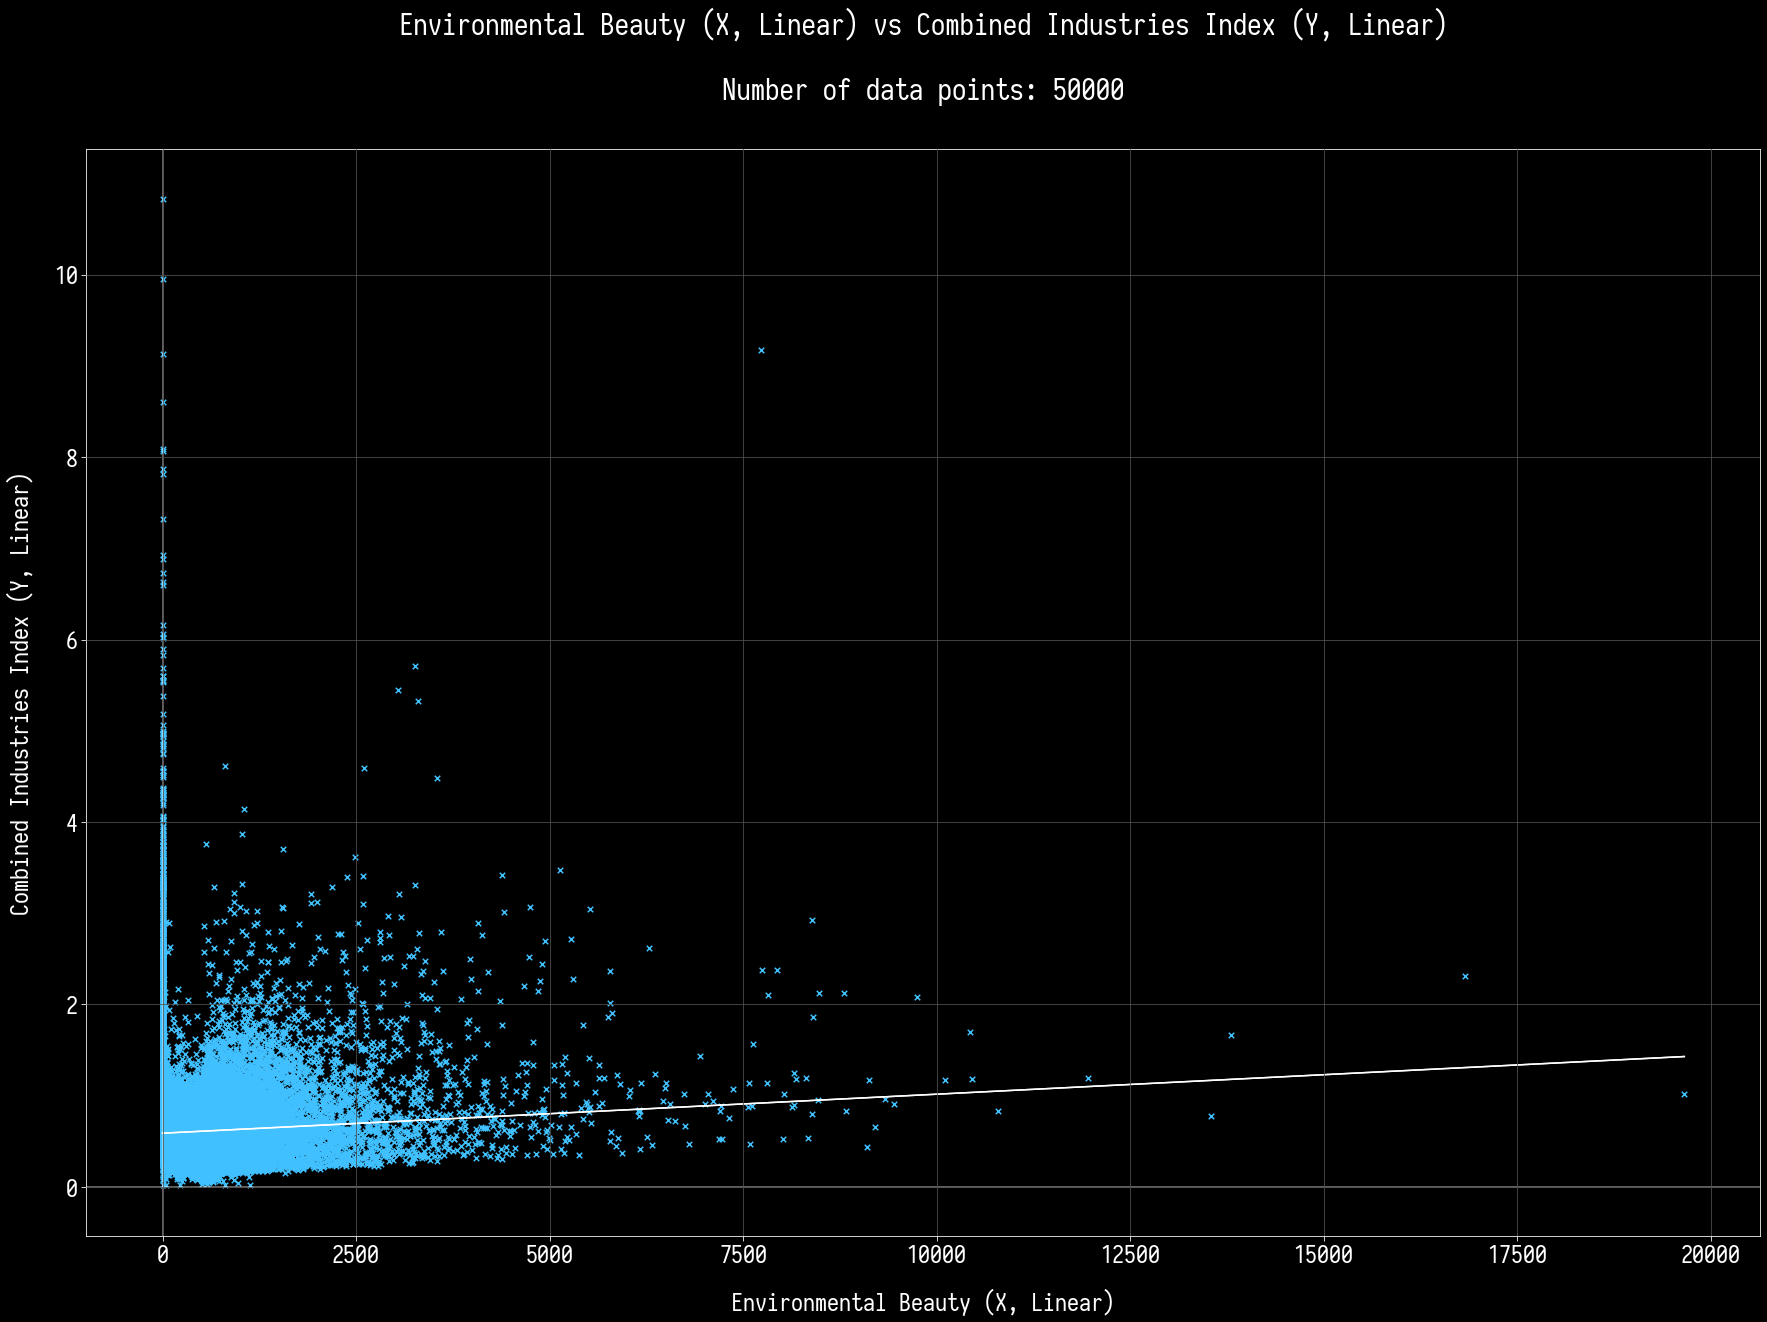

In [7]:
print("Min X:", X.min(),"// Max X:", X.max())
print("Min Y:", Y.min(),"// Max Y:", Y.max())

# AxisLin for linear, AxisLog for Symmetrical Log.
X_lab = XLin
Y_lab = YLin

linthreshx = 100
linthreshy = 100

fig = plt.figure(figsize=(30, 20))
# fig = plt.figure(figsize=(180,90))
fig.patch.set_color((0/255, 0/255, 0/255))

if X_lab == XLin:
    plt.xscale("linear")
else:
    plt.xscale("symlog", basex = 10, linthreshx = linthreshx)
    
if Y_lab == YLin:
    plt.yscale("linear")
else:
    plt.yscale("symlog", basey = 10, linthreshy = linthreshy)
    
# ---------------------------------------------------

# Set limits on graphs.
# ax.set_xlim(xmin = 0, xmax = 25000)
# ax.set_ylim(ymin = 0, ymax = 300)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Providing minor tick marks for symlog.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))

if Y_lab == YLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthreshy))

# ---------------------------------------------------

ax = fig.add_subplot()
ax.set_facecolor("black")
title = ax.set_title(X_lab + " vs " + Y_lab +"\n\n" + "Number of data points: " + str(len(df2)), pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")
    
data = ax.scatter(X, Y, c = (64/255, 192/255, 255/255), marker = "x", s = 30)

ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Y_lab, color = "white", labelpad = 20)

plt.axhline(0, color = "white", alpha = 0.5)
plt.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# ----- Regression thing. poly1d_fn is now a function which takes in x and returns an estimate for y

n = 1
coef = np.polyfit(X, Y, n)
np.set_printoptions(precision = 4)
print("Coefficients:", coef)
poly = np.poly1d(coef)
sortedpoly = np.sort(X)
plt.plot(sortedpoly, poly(sortedpoly), "-w")

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])

np.random.seed(0)

# transforming the data to include another axis
X2 = X[:, np.newaxis]
Y2 = Y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree = n)
x_poly = polynomial_features.fit_transform(X2)

model = LinearRegression()
model.fit(x_poly, Y2)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(Y2, y_poly_pred))
r2 = r2_score(Y2, y_poly_pred)
print(rmse)
print(r2)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X2, y_poly_pred), key=sort_axis)
X2, y_poly_pred = zip(*sorted_zip)

plt.plot(X2, y_poly_pred, color = 'w')

print(ordinal(n),"order polynomial. The Root-Mean Square Error is",'{:,.6g}'.format(rmse)+", the R-Squared Score is", '{:,.6g}'.format(r2) +", both accurate to 6 significant figures.")